# Bibliotecas

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import os
import sys
import optparse
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

# we need to import python modules from the $SUMO_HOME/tools directory
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

from sumolib import checkBinary  # noqa
import traci  # noqa

from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete, Space, Dict

if os.path.exists("tripinfo.xml"): os.remove("tripinfo.xml")
if os.path.exists("tripinfo_fixo.xml"): os.remove("tripinfo_fixo.xml")

# Gráfico Rede Neural

In [2]:
from matplotlib import pyplot
from math import cos, sin, atan

def NormalizeData(data):
    calc = (data - (0)) / ((20) - (0))
    if calc>1:
        return 1
    elif calc<=0.1:
        return 0.1
    else: return calc

def NormalizeData_2(data):
    calc = (data - (0)) / ((3) - (0))
    if calc>1:
        return 1
    elif calc<=0.1:
        return 0.1
    else: return calc    
    
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, tst, clr='lightblue', lph=20):
#         circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=tst, color=clr)
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=tst, color=clr, alpha=lph)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, action_value=0, obsv_value=[0,0,0,0,0]):     
        list_actions = [9.0, 11.0, 13.0]
        list_states = [7.0, 9.0, 11.0, 13.0, 15.0]
        
        for neuron in self.neurons:
            
#             print(neuron.x)
            if layerType == -1 and list_actions.index(neuron.x) == action_value:
                neuron.draw( self.neuron_radius , True, clr='red')
            elif layerType == 0:
                if list_states.index(neuron.x) == 0:
                    neuron.draw( self.neuron_radius, True, clr='black', lph=NormalizeData(obsv_value[0]))
                elif list_states.index(neuron.x) == 1:
                    neuron.draw( self.neuron_radius, True, clr='magenta', lph=NormalizeData(obsv_value[1]))
                elif list_states.index(neuron.x) == 2:
                    neuron.draw( self.neuron_radius, True, clr='gold', lph=NormalizeData(obsv_value[2]))
                elif list_states.index(neuron.x) == 3:
                    neuron.draw( self.neuron_radius, True, clr='darkgreen', lph=NormalizeData(obsv_value[3]))
                else: 
                    neuron.draw( self.neuron_radius, True, clr='red', lph=NormalizeData_2(obsv_value[4]))
            else:
                neuron.draw( self.neuron_radius , False)
                
                
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self, action_vl, obs_vl):
        pyplot.clf()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i , action_vl, obs_vl)
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show(block=False)

class DrawNN():
    def __init__( self, neural_network, act, obs ):
        self.neural_network = neural_network
        self.act = act
        self.obs = obs

    def draw( self ):
        act = self.act
        obs = self.obs
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(act, obs)

# https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network
# Fim desenho rede neural *****************************************************************

# Base trânsito

In [3]:
import pandas as pd

In [4]:
volumetria_df = pd.read_excel("volumetria.xlsx", sheet_name="Planilha5")
volumetria_df

,Tipo,MV01,MV02,MV03,MV04,MV05,MV06,MV07,MV08,MV09,MV10
0,Automóveis,61,9,40,6,79,14,3,67,1,14
1,Motos,17,2,11,1,7,9,0,23,0,6
2,Ônibus / Caminhão,3,0,5,0,0,1,0,0,0,0
3,Automóveis,63,9,46,8,71,23,7,56,3,14
4,Motos,21,3,16,3,24,2,1,16,1,5
5,Ônibus / Caminhão,0,0,6,0,5,0,2,0,0,0
6,Automóveis,63,15,46,2,70,8,4,81,3,17
7,Motos,25,2,27,1,17,0,1,17,0,4
8,Ônibus / Caminhão,0,2,0,0,1,0,1,0,0,1
9,Automóveis,41,9,31,7,71,10,2,77,5,22


In [5]:
carros_lista = {'MV01':0, 'MV02':0, 'MV03':0, 'MV04':0, 'MV05':0, 'MV06':0, 'MV07':0, 'MV08':0, 'MV09':0,'MV10':0}
motos_lista = {'MV01':0, 'MV02':0, 'MV03':0, 'MV04':0, 'MV05':0, 'MV06':0, 'MV07':0, 'MV08':0, 'MV09':0,'MV10':0}
caminhoes_lista = {'MV01':0, 'MV02':0, 'MV03':0, 'MV04':0, 'MV05':0, 'MV06':0, 'MV07':0, 'MV08':0, 'MV09':0,'MV10':0}

In [6]:
for x in carros_lista.keys():
    carros_lista[x] = [volumetria_df.query('Tipo=="Automóveis"')[x].mean(), volumetria_df.query('Tipo=="Automóveis"')[x].std()]
    motos_lista[x] = [volumetria_df.query('Tipo=="Motos"')[x].mean(), volumetria_df.query('Tipo=="Motos"')[x].std()]
    caminhoes_lista[x] = [volumetria_df.query('Tipo=="Ônibus / Caminhão"')[x].mean(), volumetria_df.query('Tipo=="Ônibus / Caminhão"')[x].std()]

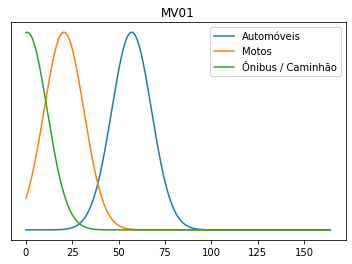

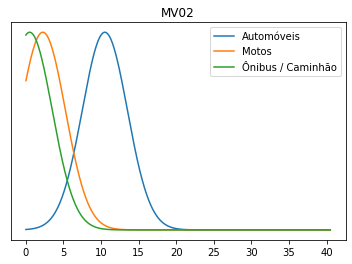

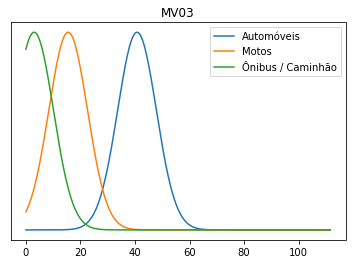

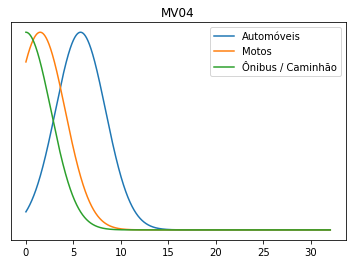

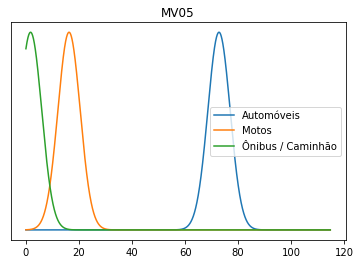

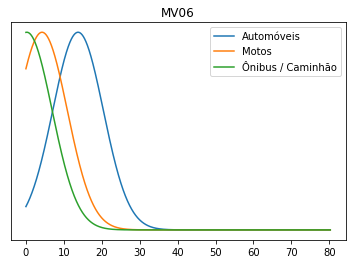

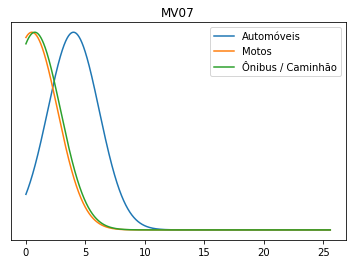

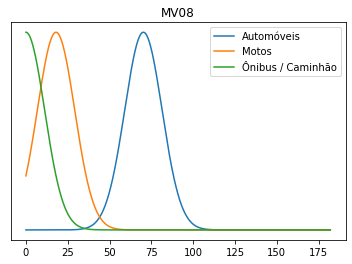

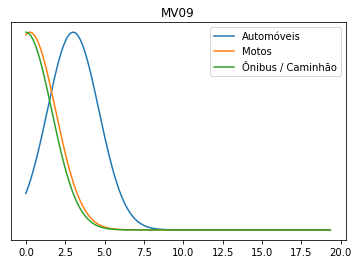

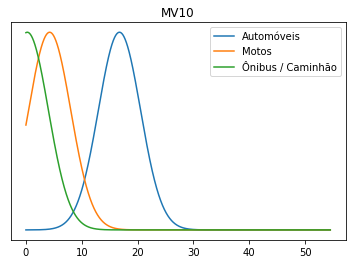

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

for x in carros_lista.keys():
# Plot between -10 and 10 with .001 steps.
    x_axis = np.arange(0, carros_lista[x][0]+10*carros_lista[x][1], 0.001)
    plt.plot(x_axis, norm.pdf(x_axis,carros_lista[x][0],carros_lista[x][1]), label='Automóveis')
    plt.plot(x_axis, norm.pdf(x_axis,motos_lista[x][0],carros_lista[x][1]), label='Motos')
    plt.plot(x_axis, norm.pdf(x_axis,caminhoes_lista[x][0],carros_lista[x][1]), label='Ônibus / Caminhão')
    plt.title(x)
    plt.yticks([])
    plt.legend()
    plt.show()

In [8]:
tran_df = pd.DataFrame(index=['MV01', 'MV02', 'MV03', 'MV04', 'MV05', 'MV06', 'MV07', 'MV08', 'MV09','MV10'], 
                       columns=['carros', 'motos', 'onibus_caminhoes', 'total'])
tran_df

,carros,motos,onibus_caminhoes,total
MV01,NaN,NaN,NaN,NaN
MV02,NaN,NaN,NaN,NaN
MV03,NaN,NaN,NaN,NaN
MV04,NaN,NaN,NaN,NaN
MV05,NaN,NaN,NaN,NaN
MV06,NaN,NaN,NaN,NaN
MV07,NaN,NaN,NaN,NaN
MV08,NaN,NaN,NaN,NaN
MV09,NaN,NaN,NaN,NaN
MV10,NaN,NaN,NaN,NaN


In [9]:
for x in tran_df.index:
    tran_df.loc[x, 'carros'] = int(np.round(np.random.normal(loc=carros_lista[x][0],scale=carros_lista[x][1],size=1).clip(min=0),0))
    tran_df.loc[x, 'motos'] = int(np.round(np.random.normal(loc=motos_lista[x][0],scale=motos_lista[x][1],size=1).clip(min=0),0))
    tran_df.loc[x, 'onibus_caminhoes'] = int(np.round(np.random.normal(loc=caminhoes_lista[x][0],scale=motos_lista[x][1],size=1).clip(min=0),0))

tran_df.total = tran_df[['carros','motos','onibus_caminhoes']].sum(axis=1).astype(int)
tran_df.total.sum()

392

In [11]:
final_lista = []

for z in tran_df.index:
    seg_rand_dict = {'carros':0,'motos':0,'onibus_caminhoes':0}
    for y in ['carros', 'motos', 'onibus_caminhoes']:
        seg_rand_list = []
        for x in (range(tran_df.loc[z,y])):
            seg_rand_list.append(random.randint(0,900))
        aux_df = pd.DataFrame(seg_rand_list, columns = ['tempo'])
        aux_df['tipo'] = y
        aux_df['mv'] = z
        final_lista.append(aux_df)
        
rand_df = pd.concat(final_lista).sort_values('tempo').reset_index(drop=True)
rand_df.shape

(392, 3)

In [13]:
def generate_routefile():
    tran_df = pd.DataFrame(index=['MV01', 'MV02', 'MV03', 'MV04', 'MV05', 'MV06', 'MV07', 'MV08', 'MV09','MV10'], 
                           columns=['carros', 'motos', 'onibus_caminhoes', 'total'])
    for x in tran_df.index:
        tran_df.loc[x, 'carros'] = int(np.round(np.random.normal(loc=carros_lista[x][0],scale=carros_lista[x][1],size=1).clip(min=0),0))
        tran_df.loc[x, 'motos'] = int(np.round(np.random.normal(loc=motos_lista[x][0],scale=motos_lista[x][1],size=1).clip(min=0),0))
        tran_df.loc[x, 'onibus_caminhoes'] = int(np.round(np.random.normal(loc=caminhoes_lista[x][0],scale=motos_lista[x][1],size=1).clip(min=0),0))

    tran_df.total = tran_df[['carros','motos','onibus_caminhoes']].sum(axis=1).astype(int)
    final_lista = []

    for z in tran_df.index:
        seg_rand_dict = {'carros':0,'motos':0,'onibus_caminhoes':0}
        for y in ['carros', 'motos', 'onibus_caminhoes']:
            seg_rand_list = []
            for x in (range(tran_df.loc[z,y])):
                seg_rand_list.append(random.randint(0,900))
            aux_df = pd.DataFrame(seg_rand_list, columns = ['tempo'])
            aux_df['tipo'] = y
            aux_df['mv'] = z
            final_lista.append(aux_df)

    rand_df = pd.concat(final_lista).sort_values('tempo').reset_index(drop=True)

# demand per second from different directions
    with open("cruzamento.rou.xml", "w") as routes:
        print("""<routes>
        <vType id="carro" accel="0.8" decel="4.5" sigma=".5" length="5" minGap="2.5" maxSpeed="22.22" speedFactor="norm(13.89,.1)" vClass="passenger" guiShape="passenger"/>
        <vType id="moto" accel="0.8" decel="4.5" sigma=".5" length="3" minGap="2.5" maxSpeed="22.22" speedFactor="norm(13.89,.1)" vClass="motorcycle" guiShape="motorcycle"/>
        <vType id="caminhao" accel="0.8" decel="4.5" sigma=".5" length="10" minGap="2.5" maxSpeed="22.22" speedFactor="norm(11.11,.1)" vClass="truck" guiShape="truck"/>
        
        <route id="mv01" edges="h4_h3 h3_tl tl_h2 h2_h1" />
        <route id="mv02" edges="h4_h3 h3_tl tl_v2 v2_v1" />
        
        <route id="mv03" edges="h1_h2 h2_tl tl_h3 h3_h4" />
        <route id="mv04" edges="h1_h2 h2_tl tl_v3 v3_v4" />
        
        <route id="mv05" edges="v1_v2 v2_tl tl_v3 v3_v4" />
        <route id="mv06" edges="v1_v2 v2_tl tl_h3 h3_h4" />
        <route id="mv07" edges="v1_v2 v2_tl tl_h2 h2_h1" />
        
        <route id="mv08" edges="v4_v3 v3_tl tl_v2 v2_v1" />
        <route id="mv09" edges="v4_v3 v3_tl tl_h3 h3_h4" />
        <route id="mv10" edges="v4_v3 v3_tl tl_h2 h2_h1" />        
        """, file=routes)

        vehNr = 0
        for x in range(len(rand_df)):
            if rand_df.iloc[x].mv == 'MV01':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv01" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv01" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv01" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)

            if rand_df.iloc[x].mv == 'MV02':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv02" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv02" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv02" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)

            if rand_df.iloc[x].mv == 'MV03':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv03" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv03" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv03" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)            

            if rand_df.iloc[x].mv == 'MV04':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv04" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv04" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv04" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                    
            if rand_df.iloc[x].mv == 'MV05':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv05" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv05" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv05" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)                    
                    
            if rand_df.iloc[x].mv == 'MV06':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv06" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv06" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv06" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)

            if rand_df.iloc[x].mv == 'MV07':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv07" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv07" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv07" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)

            if rand_df.iloc[x].mv == 'MV08':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv08" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv08" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv08" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)            

            if rand_df.iloc[x].mv == 'MV09':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv09" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv09" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv09" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                    
            if rand_df.iloc[x].mv == 'MV10':
                if rand_df.iloc[x].tipo == 'carros':
                    print('    <vehicle id="ver_%i" type="carro" route="mv10" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'motos':
                    print('    <vehicle id="ver_%i" type="moto" route="mv10" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)
                elif rand_df.iloc[x].tipo == 'onibus_caminhoes':
                    print('    <vehicle id="ver_%i" type="caminhao" route="mv10" depart="%i" departLane="random" arrivalLane="random" color="%i,%i,%i"/>' % (
                        vehNr, rand_df.iloc[x].tempo,random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)), file=routes)                                       
                    
            vehNr += 1
        print("</routes>", file=routes)
generate_routefile()

In [14]:
class ShowerEnvFixo(Env):
    def __init__(self):
        # first, generate the route file for this simulation

        # Actions we can take, down, stay, up
#         self.action_space = Discrete(1)

#        # Temperature array
#         self.observation_space = Discrete(1)
                                       
#         # Set start state
#         self.state = Discrete(1).sample()


        # Set shower length
        self.simulation_length = 900    
        
 
    def step(self):    
#         print(self.simulation_length)                
        traci.simulationStep()

        self.simulation_length -= 1 
        
        reward = 0
        
        w1 = -0.01
        w3 = -0.0025
        w5 = 1
        
        reward += w1*traci.edge.getLastStepHaltingNumber('v3_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('v2_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('h2_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('h3_tl')
        
        reward += w3*traci.edge.getWaitingTime('v3_tl')
        reward += w3*traci.edge.getWaitingTime('v2_tl')
        reward += w3*traci.edge.getWaitingTime('h2_tl')
        reward += w3*traci.edge.getWaitingTime('h3_tl') 
        
        reward += w5*(traci.edge.getLastStepVehicleNumber("tl_v2") + 
                      traci.edge.getLastStepVehicleNumber("tl_h2") + 
                      traci.edge.getLastStepVehicleNumber("tl_v3") + 
                      traci.edge.getLastStepVehicleNumber("tl_h3"))  
        

        # Check if shower is done
        if (self.simulation_length <= 0 or len(traci.simulation.getEmergencyStoppingVehiclesIDList()) != 0):
            done = True
            traci.close()
            
            temp_df = pd.read_xml('tripinfo_fixo.xml')[cols_xml]
            fx_list.append(temp_df)

        else:
            done = False            
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info
    
    def reset(self):
        # Reset start state        
        self.state = Discrete(1).sample()
        
        self.simulation_length = 900

        traci.start([checkBinary('sumo'), 
                     "-c", "01_cruzamentos_fx.sumocfg",
                     "--no-step-log", "true", 
                     "--tripinfo-output", "tripinfo_fixo.xml",  
                     "--no-warnings","true", 
                     "--start", "true", 
                     "--quit-on-end", "true",
                     "--time-to-teleport", "-1",
                     "--collision.check-junctions", "true",
                     "--window-pos", "0,0",
                     "--window-size","1280,1080",
                     "--registry-viewport","true"],
                    label="master_fixo")
        

#         logic = traci.trafficlight.Logic(programID='0', type=0, currentPhaseIndex=0, phases=(traci.trafficlight.Phase(duration=self.simulation_length, state='GGGGGrrrrr', minDur=self.simulation_length, maxDur=self.simulation_length, next=()), traci.trafficlight.Phase(duration=5.0, state='yyyyyrrrrr', minDur=5.0, maxDur=5.0, next=()), traci.trafficlight.Phase(duration=self.simulation_length, state='rrrrrGGGGG', minDur=self.simulation_length, maxDur=self.simulation_length, next=()), traci.trafficlight.Phase(duration=5.0, state='rrrrryyyyy', minDur=5.0, maxDur=5.0, next=())), subParameter={})
#         traci.trafficlight.setCompleteRedYellowGreenDefinition = traci.trafficlight.setProgramLogic("2", logic)
        
        


        # Reset shower length

        return self.state

In [15]:
class ShowerEnv(Env):
    def __init__(self):
        # first, generate the route file for this simulation
        generate_routefile()
        
        self.var_list = []

        # Actions we can take, down, stay, up
        self.action_space = Discrete(2)

       # Temperature array
        self.observation_space = Box(low=np.array(15*[0], dtype=np.float32), 
                                     high=np.array([200,200,200,200,200,200,200,200,10000,10000,10000,10000,18,2,3], dtype=np.float32), 
                                     dtype=np.float32)
                                       
        # Set start state
        self.state = Box(low=np.array(15*[0], dtype=np.float32), 
                         high=np.array(15*[0], dtype=np.float32), 
                         dtype=np.float32).sample()


        # Set shower length
        self.simulation_length = 900    
        
 
    def step(self, action):    
#         print(action)

        if action in [0]:
            pass
        
        elif action in [1]:
            if traci.trafficlight.getPhase("tl")==0:
                traci.trafficlight.setPhase("tl", 1) # aplica a ação no SUMO
            elif traci.trafficlight.getPhase("tl")==5:
                traci.trafficlight.setPhase("tl", 6)
            elif traci.trafficlight.getPhase("tl")==10:
                traci.trafficlight.setPhase("tl", 11)
                
        traci.simulationStep()
        self.tl_estados.append(traci.trafficlight.getPhase("tl"))
        # atualiza o estado
        self.state = np.array([traci.edge.getLastStepHaltingNumber("h3_tl"),
                               traci.edge.getLastStepHaltingNumber("h2_tl"),
                               traci.edge.getLastStepHaltingNumber("v2_tl"),
                               traci.edge.getLastStepHaltingNumber("v3_tl"),
                               traci.edge.getLastStepVehicleNumber("h3_tl"),
                               traci.edge.getLastStepVehicleNumber("h2_tl"),
                               traci.edge.getLastStepVehicleNumber("v2_tl"),
                               traci.edge.getLastStepVehicleNumber("v3_tl"),
                               traci.edge.getWaitingTime("h3_tl"),
                               traci.edge.getWaitingTime("h2_tl"),
                               traci.edge.getWaitingTime("v2_tl"),
                               traci.edge.getWaitingTime("v3_tl"),
                               traci.trafficlight.getPhase("tl"),
                               1 if traci.trafficlight.getPhase("tl") in [0,5,10] else 0,
                               (5 if traci.trafficlight.getPhase("tl") in [0,1,2,3,4] 
                               else 10 if traci.trafficlight.getPhase("tl") in [5,6,7,8,9]  
                               else 0 if traci.trafficlight.getPhase("tl") in [10,11,12,13,14] 
                               else 0)
                              ]
                             )
#         print(self.state)

#         print('**********************')
        # network = DrawNN( [5,12,8,3], act = action, obs = self.state)
        # network.draw()
        # pyplot.figure()

        # Reduce shower length by 1 second
        self.simulation_length -= 1 

        
        
        reward = 0
        
        w1 = -0.01
        w3 = -0.0025
        w5 = 1
        
        reward += w1*traci.edge.getLastStepHaltingNumber('v3_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('v2_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('h2_tl')
        reward += w1*traci.edge.getLastStepHaltingNumber('h3_tl')
        
        reward += w3*traci.edge.getWaitingTime('v3_tl')
        reward += w3*traci.edge.getWaitingTime('v2_tl')
        reward += w3*traci.edge.getWaitingTime('h2_tl')
        reward += w3*traci.edge.getWaitingTime('h3_tl') 
        
        reward += w5*(traci.edge.getLastStepVehicleNumber("tl_v2") + 
                      traci.edge.getLastStepVehicleNumber("tl_h2") + 
                      traci.edge.getLastStepVehicleNumber("tl_v3") + 
                      traci.edge.getLastStepVehicleNumber("tl_h3"))  
           

        # Check if shower is done
        if (self.simulation_length <= 0 or len(traci.simulation.getEmergencyStoppingVehiclesIDList()) != 0):
            done = True
            traci.close()
            
            temp_df = pd.read_xml('tripinfo.xml')[cols_xml]
            var_list.append(temp_df)
            tl_states.append(self.tl_estados) 
            
            env_fixo = ShowerEnvFixo()
            estado = env_fixo.reset()
            terminou = False
            score = 0 

            while not terminou:
                n_state, premio, terminou, info = env_fixo.step()
                score+=premio
            fx_score_list.append(score)
                        
            print('fx_score: {}, fx_waitingTime: {}, var_waitingTime: {}'.format(score, pd.read_xml('tripinfo_fixo.xml')['waitingTime'].mean(), pd.read_xml('tripinfo.xml')['waitingTime'].mean()))
            
        else:
            done = False            
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info
    
    def reset(self):
        # Reset start state

        generate_routefile()
        
        self.tl_estados = []
        
        self.state = Box(low=np.array(15*[0], dtype=np.float32), 
                         high=np.array(15*[0], dtype=np.float32), 
                         dtype=np.float32).sample()
        
        self.simulation_length = 900

        traci.start([checkBinary('sumo'), 
                     "-c", "01_cruzamentos.sumocfg",
                     "--no-step-log", "true", 
                     "--tripinfo-output", "tripinfo.xml",  
                     "--no-warnings","true", 
                     "--start", "true", 
                     "--quit-on-end", "true",
                     "--time-to-teleport", "-1",
                     "--collision.check-junctions", "true",
                     "--window-pos", "0,0",
                     "--window-size","1280,1080",
                     "--registry-viewport","true"],
                    label="master_1_cruz")
        print('__________________________________________________________________________________________')         

#         logic = traci.trafficlight.Logic(programID='0', type=0, currentPhaseIndex=0, phases=(traci.trafficlight.Phase(duration=self.simulation_length, state='GGGGGrrrrr', minDur=self.simulation_length, maxDur=self.simulation_length, next=()), traci.trafficlight.Phase(duration=5.0, state='yyyyyrrrrr', minDur=5.0, maxDur=5.0, next=()), traci.trafficlight.Phase(duration=self.simulation_length, state='rrrrrGGGGG', minDur=self.simulation_length, maxDur=self.simulation_length, next=()), traci.trafficlight.Phase(duration=5.0, state='rrrrryyyyy', minDur=5.0, maxDur=5.0, next=())), subParameter={})
#         traci.trafficlight.setCompleteRedYellowGreenDefinition = traci.trafficlight.setProgramLogic("2", logic)
        
        


        # Reset shower length

        return self.state

In [16]:
# env_fixo = ShowerEnvFixo()
# estado = env_fixo.reset()
# terminou = False
# score = 0 

# while not terminou:
#     action = env_fixo.action_space.sample()
#     n_state, reward, terminou, info = env_fixo.step(action)
#     score+=reward
# print('fx_score: {}'.format(score))

In [17]:
cols_xml = ['id', 'arrivalSpeed', 'duration', 'waitingTime', 'waitingCount', 'timeLoss']
var_list = []
fx_list = []
fx_score_list = []
tl_states = []

In [18]:
# %%capture cap_out --no-stderr

env = ShowerEnv()

# episodes = 5

# for episode in range(1, episodes+1):

#     state = env.reset()
#     done = False
#     score = 0 
    
#     while not done:
#         #env.render()
#         action = env.action_space.sample()
#         n_state, reward, done, info = env.step(action)
#         score+=reward
#     print('Episode:{} Score:{}'.format(episode, score))

# def build_model(states, actions):
#     model = Sequential()
#     model.add(Flatten(input_shape=(1,states)))
#     model.add(Dense(12, activation='relu'))
#     model.add(Dense(18, activation='relu'))
#     model.add(Dense(6, activation='relu'))
#     model.add(Dense(actions, activation='linear'))
#     return model

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(96, activation='relu'))
    model.add(Dense(192, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

states = env.observation_space.shape[0]
actions = env.action_space.n

model = build_model(states, actions)

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=2*100000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2, enable_double_dqn=True)
    return dqn

dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mse'])

train_history = dqn.fit(env, nb_steps=1000*900, visualize=False, verbose=2, log_interval=900)
# train_history = dqn.fit(env, nb_steps=5*900, visualize=False, verbose=2, log_interval=900)
# train_rewards = train_history.history['episode_reward']
# _ = dqn.test(env, nb_episodes=1, visualize=False)

# train_rewards = train_history.history['episode_reward']
# dqn.save_weights('dqn_weights.h5f', overwrite=True)

# dqn.load_weights('dqn_weights.h5f')
# _ = dqn.test(env, nb_episodes=1, visualize=False)

Training for 900000 steps ...
__________________________________________________________________________________________


C:\Users\jpsel\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


fx_score: 3437.3175000000006, fx_waitingTime: 48.472312703583064, var_waitingTime: 99.25396825396825
    900/900000: episode: 1, duration: 24.215s, episode steps: 900, steps per second:  37, episode reward: 1173.062, mean reward:  1.303 [-9.983, 16.880], mean action: 0.548 [0.000, 1.000],  loss: 5.327489, mse: 594.680634, mean_q: 25.694659
__________________________________________________________________________________________
fx_score: 3041.6000000000004, fx_waitingTime: 67.04213483146067, var_waitingTime: 182.6024844720497
   1800/900000: episode: 2, duration: 25.954s, episode steps: 900, steps per second:  35, episode reward: -38068.387, mean reward: -42.298 [-150.020, 12.855], mean action: 0.110 [0.000, 1.000],  loss: 223.246933, mse: 4358.146484, mean_q: 29.326996
__________________________________________________________________________________________
fx_score: 4143.095, fx_waitingTime: 39.709859154929575, var_waitingTime: 152.4420600858369
   2700/900000: episode: 3, duration

fx_score: 4154.862499999994, fx_waitingTime: 46.345205479452055, var_waitingTime: 93.23489932885906
  18000/900000: episode: 20, duration: 28.247s, episode steps: 900, steps per second:  32, episode reward: 1374.765, mean reward:  1.528 [-7.603, 20.642], mean action: 0.489 [0.000, 1.000],  loss: 174.365051, mse: 108308.375000, mean_q: 20.584661
__________________________________________________________________________________________
fx_score: 4140.255, fx_waitingTime: 49.99193548387097, var_waitingTime: 120.31740614334471
  18900/900000: episode: 21, duration: 27.532s, episode steps: 900, steps per second:  33, episode reward: 645.222, mean reward:  0.717 [-8.777, 16.020], mean action: 0.489 [0.000, 1.000],  loss: 654.854309, mse: 112100.835938, mean_q: 21.608545
__________________________________________________________________________________________
fx_score: 3907.6599999999953, fx_waitingTime: 39.3343653250774, var_waitingTime: 103.1923076923077
  19800/900000: episode: 22, durati

fx_score: 4179.829999999999, fx_waitingTime: 43.85558583106267, var_waitingTime: 96.7859649122807
  35100/900000: episode: 39, duration: 25.974s, episode steps: 900, steps per second:  35, episode reward: 876.505, mean reward:  0.974 [-6.775, 17.405], mean action: 0.489 [0.000, 1.000],  loss: 152.215134, mse: 46277.156250, mean_q: 77.190262
__________________________________________________________________________________________
fx_score: 4318.519999999994, fx_waitingTime: 40.54518950437318, var_waitingTime: 72.2135593220339
  36000/900000: episode: 40, duration: 25.787s, episode steps: 900, steps per second:  35, episode reward: 2214.097, mean reward:  2.460 [-8.465, 21.418], mean action: 0.416 [0.000, 1.000],  loss: 199.767029, mse: 52623.582031, mean_q: 74.418144
__________________________________________________________________________________________
fx_score: 3987.8925000000017, fx_waitingTime: 35.87613293051359, var_waitingTime: 104.37037037037037
  36900/900000: episode: 41, d

fx_score: 3926.4925, fx_waitingTime: 39.66358024691358, var_waitingTime: 102.37596899224806
  52200/900000: episode: 58, duration: 26.066s, episode steps: 900, steps per second:  35, episode reward: 764.755, mean reward:  0.850 [-7.265, 14.825], mean action: 0.459 [0.000, 1.000],  loss: 129.518784, mse: 32473.671875, mean_q: 124.411804
__________________________________________________________________________________________
fx_score: 4082.6324999999983, fx_waitingTime: 39.638728323699425, var_waitingTime: 81.15194346289752
  53100/900000: episode: 59, duration: 25.981s, episode steps: 900, steps per second:  35, episode reward: 1669.655, mean reward:  1.855 [-6.933, 16.530], mean action: 0.357 [0.000, 1.000],  loss: 118.592194, mse: 31474.824219, mean_q: 127.310242
__________________________________________________________________________________________
fx_score: 3916.5150000000012, fx_waitingTime: 49.43888888888889, var_waitingTime: 76.6820987654321
  54000/900000: episode: 60, dura

fx_score: 3033.265000000001, fx_waitingTime: 70.84239130434783, var_waitingTime: 128.15901060070672
  69300/900000: episode: 77, duration: 26.738s, episode steps: 900, steps per second:  34, episode reward: -384.685, mean reward: -0.427 [-10.837, 13.488], mean action: 0.368 [0.000, 1.000],  loss: 182.393326, mse: 35902.039062, mean_q: 128.248749
__________________________________________________________________________________________
fx_score: 3611.7650000000026, fx_waitingTime: 33.876288659793815, var_waitingTime: 60.40392156862745
  70200/900000: episode: 78, duration: 26.085s, episode steps: 900, steps per second:  35, episode reward: 2272.457, mean reward:  2.525 [-3.843, 13.067], mean action: 0.396 [0.000, 1.000],  loss: 115.757294, mse: 33472.476562, mean_q: 131.098755
__________________________________________________________________________________________
fx_score: 4268.4574999999995, fx_waitingTime: 44.11351351351351, var_waitingTime: 77.04777070063695
  71100/900000: episod

fx_score: 4257.679999999997, fx_waitingTime: 38.38352272727273, var_waitingTime: 57.81730769230769
  86400/900000: episode: 96, duration: 26.122s, episode steps: 900, steps per second:  34, episode reward: 3008.007, mean reward:  3.342 [-5.895, 20.293], mean action: 0.388 [0.000, 1.000],  loss: 119.992790, mse: 27544.732422, mean_q: 150.688232
__________________________________________________________________________________________
fx_score: 4140.287500000003, fx_waitingTime: 39.67045454545455, var_waitingTime: 56.787581699346404
  87300/900000: episode: 97, duration: 26.332s, episode steps: 900, steps per second:  34, episode reward: 2460.945, mean reward:  2.734 [-6.825, 21.277], mean action: 0.232 [0.000, 1.000],  loss: 86.523430, mse: 25152.179688, mean_q: 153.156601
__________________________________________________________________________________________
fx_score: 3464.292500000001, fx_waitingTime: 48.58045977011494, var_waitingTime: 95.64649681528662
  88200/900000: episode: 98

__________________________________________________________________________________________
fx_score: 3644.440000000005, fx_waitingTime: 59.630434782608695, var_waitingTime: 62.221902017291065
 103500/900000: episode: 115, duration: 26.837s, episode steps: 900, steps per second:  34, episode reward: 2984.457, mean reward:  3.316 [-8.340, 18.628], mean action: 0.312 [0.000, 1.000],  loss: 68.779076, mse: 32321.695312, mean_q: 177.906250
__________________________________________________________________________________________
fx_score: 3959.477500000001, fx_waitingTime: 43.1812865497076, var_waitingTime: 66.33980582524272
 104400/900000: episode: 116, duration: 26.458s, episode steps: 900, steps per second:  34, episode reward: 2118.225, mean reward:  2.354 [-8.430, 15.938], mean action: 0.331 [0.000, 1.000],  loss: 87.714890, mse: 29699.853516, mean_q: 183.205765
__________________________________________________________________________________________
fx_score: 3791.5600000000013, fx_w

__________________________________________________________________________________________
fx_score: 3768.2074999999963, fx_waitingTime: 51.60289855072464, var_waitingTime: 84.45483870967742
 120600/900000: episode: 134, duration: 27.108s, episode steps: 900, steps per second:  33, episode reward: 1672.332, mean reward:  1.858 [-8.355, 20.282], mean action: 0.314 [0.000, 1.000],  loss: 281.553650, mse: 59201.511719, mean_q: 183.809341
__________________________________________________________________________________________
fx_score: 2932.0975000000003, fx_waitingTime: 59.51401869158879, var_waitingTime: 59.453453453453456
 121500/900000: episode: 135, duration: 26.966s, episode steps: 900, steps per second:  33, episode reward: 2974.992, mean reward:  3.306 [-5.465, 20.227], mean action: 0.358 [0.000, 1.000],  loss: 141.036758, mse: 50137.296875, mean_q: 186.829788
__________________________________________________________________________________________
fx_score: 4039.692500000001, f

__________________________________________________________________________________________
fx_score: 4509.210000000004, fx_waitingTime: 42.200542005420054, var_waitingTime: 63.9208211143695
 137700/900000: episode: 153, duration: 27.312s, episode steps: 900, steps per second:  33, episode reward: 2604.417, mean reward:  2.894 [-6.468, 21.758], mean action: 0.319 [0.000, 1.000],  loss: 159.947083, mse: 58482.089844, mean_q: 190.362366
__________________________________________________________________________________________
fx_score: 4220.644999999996, fx_waitingTime: 44.007915567282325, var_waitingTime: 78.00287356321839
 138600/900000: episode: 154, duration: 27.311s, episode steps: 900, steps per second:  33, episode reward: 1871.112, mean reward:  2.079 [-9.822, 21.315], mean action: 0.257 [0.000, 1.000],  loss: 136.535400, mse: 45118.320312, mean_q: 196.054825
__________________________________________________________________________________________
fx_score: 3897.9125000000013, fx

__________________________________________________________________________________________
fx_score: 3811.547500000004, fx_waitingTime: 50.580555555555556, var_waitingTime: 70.95327102803738
 154800/900000: episode: 172, duration: 27.625s, episode steps: 900, steps per second:  33, episode reward: 461.168, mean reward:  0.512 [-19.983, 13.467], mean action: 0.269 [0.000, 1.000],  loss: 80.069313, mse: 34639.199219, mean_q: 218.340607
__________________________________________________________________________________________
fx_score: 4273.394999999996, fx_waitingTime: 45.10582010582011, var_waitingTime: 97.94620253164557
 155700/900000: episode: 173, duration: 28.204s, episode steps: 900, steps per second:  32, episode reward: 1107.842, mean reward:  1.231 [-8.765, 23.710], mean action: 0.481 [0.000, 1.000],  loss: 111.613739, mse: 35764.960938, mean_q: 217.404480
__________________________________________________________________________________________
fx_score: 4227.485000000001, fx_w

__________________________________________________________________________________________
fx_score: 3639.5299999999984, fx_waitingTime: 35.89310344827586, var_waitingTime: 57.437722419928825
 171900/900000: episode: 191, duration: 27.728s, episode steps: 900, steps per second:  32, episode reward: 2730.007, mean reward:  3.033 [-4.360, 18.740], mean action: 0.249 [0.000, 1.000],  loss: 170.002991, mse: 42137.640625, mean_q: 227.685074
__________________________________________________________________________________________
fx_score: 4085.372499999998, fx_waitingTime: 39.71987951807229, var_waitingTime: 46.470238095238095
 172800/900000: episode: 192, duration: 28.125s, episode steps: 900, steps per second:  32, episode reward: 3444.535, mean reward:  3.827 [-4.010, 23.633], mean action: 0.314 [0.000, 1.000],  loss: 73.431129, mse: 39614.195312, mean_q: 230.638626
__________________________________________________________________________________________
fx_score: 3925.1875000000005, f

__________________________________________________________________________________________
fx_score: 4466.6224999999995, fx_waitingTime: 39.0625, var_waitingTime: 62.85549132947977
 189000/900000: episode: 210, duration: 28.698s, episode steps: 900, steps per second:  31, episode reward: 3072.815, mean reward:  3.414 [-5.562, 23.718], mean action: 0.314 [0.000, 1.000],  loss: 96.413078, mse: 41482.781250, mean_q: 246.219589
__________________________________________________________________________________________
fx_score: 4342.852499999999, fx_waitingTime: 39.98076923076923, var_waitingTime: 44.798882681564244
 189900/900000: episode: 211, duration: 28.489s, episode steps: 900, steps per second:  32, episode reward: 3804.682, mean reward:  4.227 [-4.288, 23.460], mean action: 0.259 [0.000, 1.000],  loss: 99.047836, mse: 42512.355469, mean_q: 246.956314
__________________________________________________________________________________________
fx_score: 4432.837499999997, fx_waitingTime

__________________________________________________________________________________________
fx_score: 3928.610000000003, fx_waitingTime: 39.93251533742331, var_waitingTime: 49.838509316770185
 206100/900000: episode: 229, duration: 28.387s, episode steps: 900, steps per second:  32, episode reward: 3109.168, mean reward:  3.455 [-4.013, 20.365], mean action: 0.278 [0.000, 1.000],  loss: 90.009338, mse: 42360.710938, mean_q: 267.973816
__________________________________________________________________________________________
fx_score: 3925.900000000004, fx_waitingTime: 41.87888198757764, var_waitingTime: 43.67477203647417
 207000/900000: episode: 230, duration: 28.236s, episode steps: 900, steps per second:  32, episode reward: 3718.840, mean reward:  4.132 [-3.205, 22.345], mean action: 0.294 [0.000, 1.000],  loss: 93.183495, mse: 42977.519531, mean_q: 269.961029
__________________________________________________________________________________________
fx_score: 4314.059999999998, fx_wa

__________________________________________________________________________________________
fx_score: 3759.090000000002, fx_waitingTime: 57.14207650273224, var_waitingTime: 50.12637362637363
 223200/900000: episode: 248, duration: 28.515s, episode steps: 900, steps per second:  32, episode reward: 3850.923, mean reward:  4.279 [-5.455, 24.250], mean action: 0.266 [0.000, 1.000],  loss: 82.797813, mse: 47000.644531, mean_q: 287.195496
__________________________________________________________________________________________
fx_score: 4271.624999999999, fx_waitingTime: 37.39650145772595, var_waitingTime: 55.42553191489362
 224100/900000: episode: 249, duration: 28.578s, episode steps: 900, steps per second:  31, episode reward: 3349.630, mean reward:  3.722 [-4.925, 23.157], mean action: 0.297 [0.000, 1.000],  loss: 103.272865, mse: 46868.097656, mean_q: 288.408417
__________________________________________________________________________________________
fx_score: 3701.3300000000004, fx_w

__________________________________________________________________________________________
fx_score: 4250.3175, fx_waitingTime: 52.90886075949367, var_waitingTime: 70.56233421750663
 240300/900000: episode: 267, duration: 28.973s, episode steps: 900, steps per second:  31, episode reward: 3074.960, mean reward:  3.417 [-7.675, 24.575], mean action: 0.386 [0.000, 1.000],  loss: 96.717438, mse: 51977.101562, mean_q: 309.840149
__________________________________________________________________________________________
fx_score: 3516.0425000000027, fx_waitingTime: 52.798816568047336, var_waitingTime: 46.106017191977074
 241200/900000: episode: 268, duration: 28.525s, episode steps: 900, steps per second:  32, episode reward: 3425.672, mean reward:  3.806 [-4.405, 20.102], mean action: 0.301 [0.000, 1.000],  loss: 126.439651, mse: 52371.929688, mean_q: 311.554596
__________________________________________________________________________________________
fx_score: 4142.3200000000015, fx_waitin

__________________________________________________________________________________________
fx_score: 3858.7249999999963, fx_waitingTime: 49.787234042553195, var_waitingTime: 49.288770053475936
 257400/900000: episode: 286, duration: 28.630s, episode steps: 900, steps per second:  31, episode reward: 3550.615, mean reward:  3.945 [-5.718, 23.277], mean action: 0.319 [0.000, 1.000],  loss: 117.954559, mse: 56995.308594, mean_q: 328.379944
__________________________________________________________________________________________
fx_score: 3716.615, fx_waitingTime: 39.350482315112544, var_waitingTime: 52.593650793650795
 258300/900000: episode: 287, duration: 28.650s, episode steps: 900, steps per second:  31, episode reward: 3138.180, mean reward:  3.487 [-4.870, 17.852], mean action: 0.348 [0.000, 1.000],  loss: 93.027481, mse: 57314.988281, mean_q: 330.087402
__________________________________________________________________________________________
fx_score: 3919.767500000003, fx_waitin

__________________________________________________________________________________________
fx_score: 4328.989999999999, fx_waitingTime: 43.6566757493188, var_waitingTime: 58.29526462395543
 274500/900000: episode: 305, duration: 28.118s, episode steps: 900, steps per second:  32, episode reward: 3407.898, mean reward:  3.787 [-5.607, 20.225], mean action: 0.310 [0.000, 1.000],  loss: 85.268410, mse: 59099.562500, mean_q: 339.206360
__________________________________________________________________________________________
fx_score: 3879.3875000000007, fx_waitingTime: 49.23314606741573, var_waitingTime: 70.54545454545455
 275400/900000: episode: 306, duration: 28.839s, episode steps: 900, steps per second:  31, episode reward: 2807.220, mean reward:  3.119 [-7.040, 20.945], mean action: 0.287 [0.000, 1.000],  loss: 91.803490, mse: 59456.828125, mean_q: 341.047150
__________________________________________________________________________________________
fx_score: 3793.1599999999994, fx_wa

__________________________________________________________________________________________
fx_score: 3929.7450000000017, fx_waitingTime: 46.31845238095238, var_waitingTime: 50.1044776119403
 291600/900000: episode: 324, duration: 28.617s, episode steps: 900, steps per second:  31, episode reward: 3479.190, mean reward:  3.866 [-4.065, 23.427], mean action: 0.296 [0.000, 1.000],  loss: 126.934166, mse: 62255.773438, mean_q: 351.421204
__________________________________________________________________________________________
fx_score: 3723.5099999999984, fx_waitingTime: 42.165109034267914, var_waitingTime: 54.38906752411575
 292500/900000: episode: 325, duration: 28.317s, episode steps: 900, steps per second:  32, episode reward: 2791.145, mean reward:  3.101 [-5.275, 19.363], mean action: 0.336 [0.000, 1.000],  loss: 116.660240, mse: 61894.773438, mean_q: 350.081757
__________________________________________________________________________________________
fx_score: 4342.135000000005, fx

__________________________________________________________________________________________
fx_score: 3975.112499999999, fx_waitingTime: 40.133136094674555, var_waitingTime: 48.659701492537316
 308700/900000: episode: 343, duration: 28.542s, episode steps: 900, steps per second:  32, episode reward: 3555.400, mean reward:  3.950 [-4.195, 18.488], mean action: 0.301 [0.000, 1.000],  loss: 102.148788, mse: 62604.718750, mean_q: 351.861603
__________________________________________________________________________________________
fx_score: 3975.709999999993, fx_waitingTime: 53.61878453038674, var_waitingTime: 56.745152354570635
 309600/900000: episode: 344, duration: 28.684s, episode steps: 900, steps per second:  31, episode reward: 3346.880, mean reward:  3.719 [-5.643, 18.555], mean action: 0.314 [0.000, 1.000],  loss: 107.797745, mse: 63506.453125, mean_q: 353.936737
__________________________________________________________________________________________
fx_score: 4390.929999999997, f

__________________________________________________________________________________________
fx_score: 4017.78, fx_waitingTime: 41.50704225352113, var_waitingTime: 51.72364672364672
 325800/900000: episode: 362, duration: 28.806s, episode steps: 900, steps per second:  31, episode reward: 3345.685, mean reward:  3.717 [-6.553, 22.355], mean action: 0.277 [0.000, 1.000],  loss: 86.537415, mse: 66137.296875, mean_q: 363.291382
__________________________________________________________________________________________
fx_score: 4278.810000000004, fx_waitingTime: 36.642857142857146, var_waitingTime: 45.959537572254334
 326700/900000: episode: 363, duration: 28.428s, episode steps: 900, steps per second:  32, episode reward: 3480.580, mean reward:  3.867 [-3.840, 22.905], mean action: 0.203 [0.000, 1.000],  loss: 115.394150, mse: 66728.726562, mean_q: 364.801117
__________________________________________________________________________________________
fx_score: 3877.0874999999955, fx_waitingTi

__________________________________________________________________________________________
fx_score: 3791.3850000000007, fx_waitingTime: 43.53550295857988, var_waitingTime: 44.18980169971671
 342900/900000: episode: 381, duration: 28.553s, episode steps: 900, steps per second:  32, episode reward: 3957.658, mean reward:  4.397 [-4.338, 19.915], mean action: 0.309 [0.000, 1.000],  loss: 112.301926, mse: 67510.476562, mean_q: 367.099060
__________________________________________________________________________________________
fx_score: 4210.909999999998, fx_waitingTime: 40.790055248618785, var_waitingTime: 45.15041782729805
 343800/900000: episode: 382, duration: 28.687s, episode steps: 900, steps per second:  31, episode reward: 3676.468, mean reward:  4.085 [-4.857, 24.240], mean action: 0.311 [0.000, 1.000],  loss: 131.824265, mse: 67127.554688, mean_q: 367.377014
__________________________________________________________________________________________
fx_score: 4002.602500000001, fx

__________________________________________________________________________________________
fx_score: 4271.76, fx_waitingTime: 40.670422535211266, var_waitingTime: 42.97398843930636
 360000/900000: episode: 400, duration: 28.369s, episode steps: 900, steps per second:  32, episode reward: 3754.837, mean reward:  4.172 [-4.875, 26.960], mean action: 0.211 [0.000, 1.000],  loss: 122.751045, mse: 70844.554688, mean_q: 378.541382
__________________________________________________________________________________________
fx_score: 2981.8300000000027, fx_waitingTime: 65.97866666666667, var_waitingTime: 57.885117493472585
 360900/900000: episode: 401, duration: 28.467s, episode steps: 900, steps per second:  32, episode reward: 3252.530, mean reward:  3.614 [-9.492, 25.420], mean action: 0.224 [0.000, 1.000],  loss: 113.515297, mse: 71089.476562, mean_q: 379.813110
__________________________________________________________________________________________
fx_score: 3723.265000000001, fx_waitingT

__________________________________________________________________________________________
fx_score: 4028.8999999999965, fx_waitingTime: 45.63661202185792, var_waitingTime: 49.696883852691215
 377100/900000: episode: 419, duration: 28.749s, episode steps: 900, steps per second:  31, episode reward: 3106.315, mean reward:  3.451 [-5.818, 22.933], mean action: 0.250 [0.000, 1.000],  loss: 103.992012, mse: 73338.523438, mean_q: 385.593658
__________________________________________________________________________________________
fx_score: 3788.8524999999972, fx_waitingTime: 57.21164021164021, var_waitingTime: 60.71967654986523
 378000/900000: episode: 420, duration: 28.820s, episode steps: 900, steps per second:  31, episode reward: 2589.318, mean reward:  2.877 [-8.970, 21.843], mean action: 0.252 [0.000, 1.000],  loss: 138.249420, mse: 72513.078125, mean_q: 384.358459
__________________________________________________________________________________________
fx_score: 3870.3524999999963, 

__________________________________________________________________________________________
fx_score: 3966.849999999999, fx_waitingTime: 37.9969040247678, var_waitingTime: 45.36305732484077
 394200/900000: episode: 438, duration: 28.343s, episode steps: 900, steps per second:  32, episode reward: 3079.542, mean reward:  3.422 [-4.843, 19.288], mean action: 0.230 [0.000, 1.000],  loss: 135.262421, mse: 71531.484375, mean_q: 379.869934
__________________________________________________________________________________________
fx_score: 4348.652500000002, fx_waitingTime: 35.174698795180724, var_waitingTime: 40.92920353982301
 395100/900000: episode: 439, duration: 28.351s, episode steps: 900, steps per second:  32, episode reward: 3700.032, mean reward:  4.111 [-4.567, 24.305], mean action: 0.273 [0.000, 1.000],  loss: 115.344994, mse: 71591.570312, mean_q: 379.118744
__________________________________________________________________________________________
fx_score: 4350.744999999997, fx_w

__________________________________________________________________________________________
fx_score: 3780.0500000000034, fx_waitingTime: 47.01169590643275, var_waitingTime: 57.17263843648208
 411300/900000: episode: 457, duration: 28.744s, episode steps: 900, steps per second:  31, episode reward: 2364.498, mean reward:  2.627 [-6.210, 18.205], mean action: 0.317 [0.000, 1.000],  loss: 93.541672, mse: 70642.671875, mean_q: 378.081451
__________________________________________________________________________________________
fx_score: 4080.037499999997, fx_waitingTime: 41.753799392097264, var_waitingTime: 47.105421686746986
 412200/900000: episode: 458, duration: 28.090s, episode steps: 900, steps per second:  32, episode reward: 3318.477, mean reward:  3.687 [-5.080, 22.938], mean action: 0.173 [0.000, 1.000],  loss: 136.091339, mse: 71031.523438, mean_q: 379.419403
__________________________________________________________________________________________
fx_score: 3988.6924999999987, f

__________________________________________________________________________________________
fx_score: 4232.347499999999, fx_waitingTime: 37.017910447761196, var_waitingTime: 51.006024096385545
 428400/900000: episode: 476, duration: 28.455s, episode steps: 900, steps per second:  32, episode reward: 3387.570, mean reward:  3.764 [-6.433, 21.390], mean action: 0.303 [0.000, 1.000],  loss: 113.325554, mse: 70230.492188, mean_q: 375.544830
__________________________________________________________________________________________
fx_score: 4228.259999999991, fx_waitingTime: 35.830357142857146, var_waitingTime: 39.27893175074184
 429300/900000: episode: 477, duration: 28.398s, episode steps: 900, steps per second:  32, episode reward: 3666.043, mean reward:  4.073 [-4.883, 25.290], mean action: 0.241 [0.000, 1.000],  loss: 144.595490, mse: 69986.554688, mean_q: 375.082092
__________________________________________________________________________________________
fx_score: 3900.7425000000003, 

__________________________________________________________________________________________
fx_score: 3649.4475000000043, fx_waitingTime: 46.04733727810651, var_waitingTime: 43.94277108433735
 445500/900000: episode: 495, duration: 28.447s, episode steps: 900, steps per second:  32, episode reward: 3606.182, mean reward:  4.007 [-4.208, 20.983], mean action: 0.281 [0.000, 1.000],  loss: 125.888504, mse: 70927.078125, mean_q: 377.856598
__________________________________________________________________________________________
fx_score: 4545.562499999991, fx_waitingTime: 40.9597855227882, var_waitingTime: 45.92838196286472
 446400/900000: episode: 496, duration: 28.699s, episode steps: 900, steps per second:  31, episode reward: 4048.127, mean reward:  4.498 [-5.585, 22.273], mean action: 0.252 [0.000, 1.000],  loss: 114.811623, mse: 71112.578125, mean_q: 378.060974
__________________________________________________________________________________________
fx_score: 3708.1775000000034, fx_

__________________________________________________________________________________________
fx_score: 3997.525000000002, fx_waitingTime: 45.57703081232493, var_waitingTime: 60.63636363636363
 462600/900000: episode: 514, duration: 28.505s, episode steps: 900, steps per second:  32, episode reward: 3464.733, mean reward:  3.850 [-5.673, 15.935], mean action: 0.322 [0.000, 1.000],  loss: 137.858734, mse: 70334.851562, mean_q: 373.705566
__________________________________________________________________________________________
fx_score: 4125.899999999999, fx_waitingTime: 40.145348837209305, var_waitingTime: 63.701863354037265
 463500/900000: episode: 515, duration: 28.409s, episode steps: 900, steps per second:  32, episode reward: 2847.630, mean reward:  3.164 [-6.120, 17.410], mean action: 0.307 [0.000, 1.000],  loss: 129.729584, mse: 69624.492188, mean_q: 371.458069
__________________________________________________________________________________________
fx_score: 4086.320000000002, fx

__________________________________________________________________________________________
fx_score: 4287.420000000005, fx_waitingTime: 39.837606837606835, var_waitingTime: 63.91530944625407
 479700/900000: episode: 533, duration: 28.361s, episode steps: 900, steps per second:  32, episode reward: 2683.720, mean reward:  2.982 [-7.178, 19.707], mean action: 0.358 [0.000, 1.000],  loss: 120.769867, mse: 67867.984375, mean_q: 361.909302
__________________________________________________________________________________________
fx_score: 3924.7975, fx_waitingTime: 45.61834319526627, var_waitingTime: 59.19452887537994
 480600/900000: episode: 534, duration: 28.188s, episode steps: 900, steps per second:  32, episode reward: 3292.390, mean reward:  3.658 [-5.670, 24.703], mean action: 0.348 [0.000, 1.000],  loss: 128.389404, mse: 67838.632812, mean_q: 361.826874
__________________________________________________________________________________________
fx_score: 3573.6799999999976, fx_waiting

__________________________________________________________________________________________
fx_score: 4000.8224999999998, fx_waitingTime: 38.27414330218068, var_waitingTime: 48.144654088050316
 496800/900000: episode: 552, duration: 28.365s, episode steps: 900, steps per second:  32, episode reward: 3581.715, mean reward:  3.980 [-4.345, 22.705], mean action: 0.322 [0.000, 1.000],  loss: 141.004898, mse: 68016.921875, mean_q: 357.025757
__________________________________________________________________________________________
fx_score: 4097.394999999995, fx_waitingTime: 51.12396694214876, var_waitingTime: 105.7969696969697
 497700/900000: episode: 553, duration: 28.923s, episode steps: 900, steps per second:  31, episode reward: 1569.725, mean reward:  1.744 [-10.200, 19.008], mean action: 0.329 [0.000, 1.000],  loss: 121.371735, mse: 67517.242188, mean_q: 354.776459
__________________________________________________________________________________________
fx_score: 3046.835000000005, f

__________________________________________________________________________________________
fx_score: 4080.9050000000066, fx_waitingTime: 40.21114369501466, var_waitingTime: 101.21602787456446
 513900/900000: episode: 571, duration: 28.784s, episode steps: 900, steps per second:  31, episode reward: 1206.420, mean reward:  1.340 [-8.745, 22.750], mean action: 0.383 [0.000, 1.000],  loss: 132.792160, mse: 65464.250000, mean_q: 344.088348
__________________________________________________________________________________________
fx_score: 4070.6124999999993, fx_waitingTime: 41.96866096866097, var_waitingTime: 86.59722222222223
 514800/900000: episode: 572, duration: 28.850s, episode steps: 900, steps per second:  31, episode reward: 1264.932, mean reward:  1.405 [-8.860, 18.450], mean action: 0.452 [0.000, 1.000],  loss: 168.676331, mse: 64851.074219, mean_q: 343.322632
__________________________________________________________________________________________
fx_score: 3770.875000000001, f

__________________________________________________________________________________________
fx_score: 4241.750000000002, fx_waitingTime: 38.35511363636363, var_waitingTime: 71.50149253731344
 531000/900000: episode: 590, duration: 28.673s, episode steps: 900, steps per second:  31, episode reward: 2947.217, mean reward:  3.275 [-7.735, 19.895], mean action: 0.323 [0.000, 1.000],  loss: 138.072678, mse: 59257.359375, mean_q: 320.972626
__________________________________________________________________________________________
fx_score: 4088.7749999999987, fx_waitingTime: 45.63172804532578, var_waitingTime: 67.73860182370821
 531900/900000: episode: 591, duration: 28.749s, episode steps: 900, steps per second:  31, episode reward: 2857.345, mean reward:  3.175 [-6.865, 18.670], mean action: 0.343 [0.000, 1.000],  loss: 113.878014, mse: 59500.906250, mean_q: 320.144318
__________________________________________________________________________________________
fx_score: 3901.220000000004, fx_

__________________________________________________________________________________________
fx_score: 3391.7974999999983, fx_waitingTime: 58.209366391184574, var_waitingTime: 87.46060606060605
 548100/900000: episode: 609, duration: 29.098s, episode steps: 900, steps per second:  31, episode reward: 1580.693, mean reward:  1.756 [-9.873, 20.385], mean action: 0.341 [0.000, 1.000],  loss: 110.536217, mse: 57791.359375, mean_q: 315.986389
__________________________________________________________________________________________
fx_score: 4123.247499999997, fx_waitingTime: 44.54415954415954, var_waitingTime: 81.26923076923077
 549000/900000: episode: 610, duration: 28.776s, episode steps: 900, steps per second:  31, episode reward: 2113.945, mean reward:  2.349 [-8.283, 16.060], mean action: 0.418 [0.000, 1.000],  loss: 122.652382, mse: 57940.417969, mean_q: 316.808441
__________________________________________________________________________________________
fx_score: 3972.474999999997, fx

__________________________________________________________________________________________
fx_score: 4077.7850000000017, fx_waitingTime: 40.87278106508876, var_waitingTime: 55.916666666666664
 565200/900000: episode: 628, duration: 28.504s, episode steps: 900, steps per second:  32, episode reward: 3189.155, mean reward:  3.544 [-5.368, 25.910], mean action: 0.252 [0.000, 1.000],  loss: 116.950806, mse: 56730.746094, mean_q: 313.269806
__________________________________________________________________________________________
fx_score: 3814.9400000000014, fx_waitingTime: 47.24925816023739, var_waitingTime: 69.63311688311688
 566100/900000: episode: 629, duration: 28.625s, episode steps: 900, steps per second:  31, episode reward: 2181.180, mean reward:  2.424 [-8.160, 11.907], mean action: 0.340 [0.000, 1.000],  loss: 126.175385, mse: 56856.136719, mean_q: 314.145599
__________________________________________________________________________________________
fx_score: 4143.742500000001, f

__________________________________________________________________________________________
fx_score: 4226.330000000004, fx_waitingTime: 42.60445682451253, var_waitingTime: 44.42016806722689
 582300/900000: episode: 647, duration: 28.707s, episode steps: 900, steps per second:  31, episode reward: 3766.065, mean reward:  4.185 [-4.223, 22.492], mean action: 0.282 [0.000, 1.000],  loss: 106.365356, mse: 55063.902344, mean_q: 304.075897
__________________________________________________________________________________________
fx_score: 3768.067500000003, fx_waitingTime: 57.06005221932115, var_waitingTime: 79.05846153846154
 583200/900000: episode: 648, duration: 28.874s, episode steps: 900, steps per second:  31, episode reward: 1600.697, mean reward:  1.779 [-6.768, 22.770], mean action: 0.451 [0.000, 1.000],  loss: 114.496750, mse: 54982.906250, mean_q: 301.473877
__________________________________________________________________________________________
fx_score: 4107.822500000001, fx_w

__________________________________________________________________________________________
fx_score: 3762.737500000003, fx_waitingTime: 36.85016286644951, var_waitingTime: 42.48160535117057
 599400/900000: episode: 666, duration: 28.357s, episode steps: 900, steps per second:  32, episode reward: 2995.095, mean reward:  3.328 [-3.730, 18.363], mean action: 0.250 [0.000, 1.000],  loss: 155.301559, mse: 56060.062500, mean_q: 311.949677
__________________________________________________________________________________________
fx_score: 3950.352499999993, fx_waitingTime: 56.47680412371134, var_waitingTime: 72.53935860058309
 600300/900000: episode: 667, duration: 28.772s, episode steps: 900, steps per second:  31, episode reward: 2198.972, mean reward:  2.443 [-8.207, 22.218], mean action: 0.411 [0.000, 1.000],  loss: 171.597580, mse: 55723.480469, mean_q: 312.239105
__________________________________________________________________________________________
fx_score: 4561.877499999994, fx_w

__________________________________________________________________________________________
fx_score: 3997.1575000000007, fx_waitingTime: 42.92655367231639, var_waitingTime: 51.29085872576177
 616500/900000: episode: 685, duration: 28.866s, episode steps: 900, steps per second:  31, episode reward: 3492.227, mean reward:  3.880 [-6.210, 24.990], mean action: 0.250 [0.000, 1.000],  loss: 130.094452, mse: 54379.117188, mean_q: 306.274109
__________________________________________________________________________________________
fx_score: 4025.0699999999965, fx_waitingTime: 40.42168674698795, var_waitingTime: 46.10334346504559
 617400/900000: episode: 686, duration: 28.508s, episode steps: 900, steps per second:  32, episode reward: 3409.165, mean reward:  3.788 [-4.067, 23.570], mean action: 0.276 [0.000, 1.000],  loss: 169.278641, mse: 54742.187500, mean_q: 306.000763
__________________________________________________________________________________________
fx_score: 3301.8799999999997, f

__________________________________________________________________________________________
fx_score: 3984.2975, fx_waitingTime: 44.10481586402266, var_waitingTime: 46.20520231213873
 633600/900000: episode: 704, duration: 28.418s, episode steps: 900, steps per second:  32, episode reward: 3529.158, mean reward:  3.921 [-4.390, 20.470], mean action: 0.269 [0.000, 1.000],  loss: 84.632988, mse: 53339.761719, mean_q: 306.281952
__________________________________________________________________________________________
fx_score: 3961.092500000001, fx_waitingTime: 48.72727272727273, var_waitingTime: 42.83462532299742
 634500/900000: episode: 705, duration: 28.726s, episode steps: 900, steps per second:  31, episode reward: 4177.948, mean reward:  4.642 [-5.040, 19.142], mean action: 0.274 [0.000, 1.000],  loss: 96.302277, mse: 53518.910156, mean_q: 306.834198
__________________________________________________________________________________________
fx_score: 3800.902499999999, fx_waitingTime

__________________________________________________________________________________________
fx_score: 3800.5275000000033, fx_waitingTime: 45.61271676300578, var_waitingTime: 51.2463768115942
 650700/900000: episode: 723, duration: 28.533s, episode steps: 900, steps per second:  32, episode reward: 3847.348, mean reward:  4.275 [-4.345, 17.510], mean action: 0.386 [0.000, 1.000],  loss: 93.431366, mse: 54321.187500, mean_q: 308.140442
__________________________________________________________________________________________
fx_score: 3962.1174999999967, fx_waitingTime: 38.97560975609756, var_waitingTime: 62.412213740458014
 651600/900000: episode: 724, duration: 28.783s, episode steps: 900, steps per second:  31, episode reward: 1638.903, mean reward:  1.821 [-7.062, 13.533], mean action: 0.506 [0.000, 1.000],  loss: 107.087372, mse: 55112.117188, mean_q: 311.450409
__________________________________________________________________________________________
fx_score: 4110.887500000003, fx_

__________________________________________________________________________________________
fx_score: 3903.592500000002, fx_waitingTime: 47.30494505494506, var_waitingTime: 45.258855585831064
 667800/900000: episode: 742, duration: 28.595s, episode steps: 900, steps per second:  31, episode reward: 3860.415, mean reward:  4.289 [-4.048, 22.523], mean action: 0.280 [0.000, 1.000],  loss: 89.189514, mse: 55404.445312, mean_q: 318.291809
__________________________________________________________________________________________
fx_score: 3651.450000000002, fx_waitingTime: 45.30061349693251, var_waitingTime: 47.084848484848486
 668700/900000: episode: 743, duration: 28.938s, episode steps: 900, steps per second:  31, episode reward: 3287.030, mean reward:  3.652 [-4.173, 17.262], mean action: 0.297 [0.000, 1.000],  loss: 112.556656, mse: 55872.746094, mean_q: 319.863861
__________________________________________________________________________________________
fx_score: 3613.6275000000064, fx

__________________________________________________________________________________________
fx_score: 4373.5949999999975, fx_waitingTime: 39.98309859154929, var_waitingTime: 50.84225352112676
 684900/900000: episode: 761, duration: 28.474s, episode steps: 900, steps per second:  32, episode reward: 3958.848, mean reward:  4.399 [-4.713, 22.160], mean action: 0.384 [0.000, 1.000],  loss: 121.493996, mse: 59346.050781, mean_q: 331.353149
__________________________________________________________________________________________
fx_score: 3800.5575, fx_waitingTime: 52.067567567567565, var_waitingTime: 60.15300546448088
 685800/900000: episode: 762, duration: 28.785s, episode steps: 900, steps per second:  31, episode reward: 3362.532, mean reward:  3.736 [-6.400, 18.960], mean action: 0.340 [0.000, 1.000],  loss: 106.907806, mse: 60127.894531, mean_q: 334.341003
__________________________________________________________________________________________
fx_score: 4164.235000000002, fx_waiting

__________________________________________________________________________________________
fx_score: 4389.565000000001, fx_waitingTime: 40.13008130081301, var_waitingTime: 54.28333333333333
 702000/900000: episode: 780, duration: 28.592s, episode steps: 900, steps per second:  31, episode reward: 3728.150, mean reward:  4.142 [-4.957, 20.875], mean action: 0.333 [0.000, 1.000],  loss: 119.620132, mse: 61817.375000, mean_q: 340.004700
__________________________________________________________________________________________
fx_score: 3539.9075000000003, fx_waitingTime: 34.56363636363636, var_waitingTime: 39.967032967032964
 702900/900000: episode: 781, duration: 28.431s, episode steps: 900, steps per second:  32, episode reward: 2913.512, mean reward:  3.237 [-3.425, 24.543], mean action: 0.260 [0.000, 1.000],  loss: 139.677032, mse: 62328.738281, mean_q: 340.936920
__________________________________________________________________________________________
fx_score: 4004.6850000000013, f

__________________________________________________________________________________________
fx_score: 4412.355000000003, fx_waitingTime: 41.38666666666666, var_waitingTime: 45.22865013774105
 719100/900000: episode: 799, duration: 28.791s, episode steps: 900, steps per second:  31, episode reward: 3901.960, mean reward:  4.336 [-5.498, 20.920], mean action: 0.309 [0.000, 1.000],  loss: 119.134430, mse: 64993.101562, mean_q: 355.170074
__________________________________________________________________________________________
fx_score: 4066.240000000003, fx_waitingTime: 46.736111111111114, var_waitingTime: 46.7590027700831
 720000/900000: episode: 800, duration: 28.937s, episode steps: 900, steps per second:  31, episode reward: 3669.387, mean reward:  4.077 [-4.910, 21.255], mean action: 0.273 [0.000, 1.000],  loss: 137.084167, mse: 64703.859375, mean_q: 355.128326
__________________________________________________________________________________________
fx_score: 3560.377499999997, fx_w

__________________________________________________________________________________________
fx_score: 4048.9075000000043, fx_waitingTime: 39.47714285714286, var_waitingTime: 52.55942028985507
 736200/900000: episode: 818, duration: 28.902s, episode steps: 900, steps per second:  31, episode reward: 3171.980, mean reward:  3.524 [-6.145, 18.773], mean action: 0.277 [0.000, 1.000],  loss: 145.482635, mse: 68577.054688, mean_q: 369.620758
__________________________________________________________________________________________
fx_score: 3905.0250000000074, fx_waitingTime: 43.49122807017544, var_waitingTime: 77.83116883116882
 737100/900000: episode: 819, duration: 28.730s, episode steps: 900, steps per second:  31, episode reward: 2092.653, mean reward:  2.325 [-8.703, 17.968], mean action: 0.389 [0.000, 1.000],  loss: 131.967453, mse: 68529.687500, mean_q: 368.881989
__________________________________________________________________________________________
fx_score: 3767.6125000000025, f

__________________________________________________________________________________________
fx_score: 3873.8874999999975, fx_waitingTime: 37.736507936507934, var_waitingTime: 46.23684210526316
 753300/900000: episode: 837, duration: 28.379s, episode steps: 900, steps per second:  32, episode reward: 3133.702, mean reward:  3.482 [-5.293, 20.345], mean action: 0.293 [0.000, 1.000],  loss: 132.812988, mse: 74177.476562, mean_q: 383.910889
__________________________________________________________________________________________
fx_score: 4119.934999999996, fx_waitingTime: 37.65868263473054, var_waitingTime: 49.45962732919255
 754200/900000: episode: 838, duration: 28.993s, episode steps: 900, steps per second:  31, episode reward: 3219.108, mean reward:  3.577 [-6.465, 20.938], mean action: 0.283 [0.000, 1.000],  loss: 109.050323, mse: 74328.898438, mean_q: 384.967224
__________________________________________________________________________________________
fx_score: 4382.287499999997, fx

__________________________________________________________________________________________
fx_score: 4345.355, fx_waitingTime: 44.252604166666664, var_waitingTime: 46.223404255319146
 770400/900000: episode: 856, duration: 29.028s, episode steps: 900, steps per second:  31, episode reward: 4081.380, mean reward:  4.535 [-5.018, 22.635], mean action: 0.274 [0.000, 1.000],  loss: 106.088730, mse: 71221.367188, mean_q: 376.853271
__________________________________________________________________________________________
fx_score: 3779.2174999999997, fx_waitingTime: 45.71951219512195, var_waitingTime: 43.02439024390244
 771300/900000: episode: 857, duration: 28.389s, episode steps: 900, steps per second:  32, episode reward: 3249.818, mean reward:  3.611 [-4.717, 22.305], mean action: 0.267 [0.000, 1.000],  loss: 113.344872, mse: 71015.843750, mean_q: 377.601379
__________________________________________________________________________________________
fx_score: 3759.7625000000025, fx_waitin

__________________________________________________________________________________________
fx_score: 4134.577500000006, fx_waitingTime: 38.22418879056047, var_waitingTime: 63.4811320754717
 787500/900000: episode: 875, duration: 28.691s, episode steps: 900, steps per second:  31, episode reward: 2775.498, mean reward:  3.084 [-6.825, 19.950], mean action: 0.277 [0.000, 1.000],  loss: 136.168198, mse: 73239.750000, mean_q: 384.216064
__________________________________________________________________________________________
fx_score: 3987.8175, fx_waitingTime: 43.623931623931625, var_waitingTime: 97.82575757575758
 788400/900000: episode: 876, duration: 28.779s, episode steps: 900, steps per second:  31, episode reward: -151.763, mean reward: -0.169 [-8.665, 16.402], mean action: 0.318 [0.000, 1.000],  loss: 132.171768, mse: 72823.429688, mean_q: 384.134857
__________________________________________________________________________________________
fx_score: 3517.334999999995, fx_waitingTi

__________________________________________________________________________________________
fx_score: 3964.752499999997, fx_waitingTime: 37.91394658753709, var_waitingTime: 46.35693215339233
 804600/900000: episode: 894, duration: 29.498s, episode steps: 900, steps per second:  31, episode reward: 3559.680, mean reward:  3.955 [-3.950, 22.883], mean action: 0.278 [0.000, 1.000],  loss: 96.497932, mse: 73576.109375, mean_q: 384.473633
__________________________________________________________________________________________
fx_score: 3518.3925000000004, fx_waitingTime: 52.15151515151515, var_waitingTime: 44.495440729483285
 805500/900000: episode: 895, duration: 29.480s, episode steps: 900, steps per second:  31, episode reward: 3509.430, mean reward:  3.899 [-4.283, 19.683], mean action: 0.248 [0.000, 1.000],  loss: 119.544426, mse: 73163.031250, mean_q: 383.919128
__________________________________________________________________________________________
fx_score: 4315.852499999999, fx_

__________________________________________________________________________________________
fx_score: 4006.5825000000054, fx_waitingTime: 42.32471264367816, var_waitingTime: 43.326530612244895
 821700/900000: episode: 913, duration: 28.071s, episode steps: 900, steps per second:  32, episode reward: 3669.807, mean reward:  4.078 [-3.833, 22.670], mean action: 0.240 [0.000, 1.000],  loss: 98.336578, mse: 71572.882812, mean_q: 379.450623
__________________________________________________________________________________________
fx_score: 4136.537500000003, fx_waitingTime: 41.3371104815864, var_waitingTime: 43.624633431085044
 822600/900000: episode: 914, duration: 27.804s, episode steps: 900, steps per second:  32, episode reward: 3678.305, mean reward:  4.087 [-4.607, 20.527], mean action: 0.238 [0.000, 1.000],  loss: 123.543510, mse: 72465.148438, mean_q: 381.413818
__________________________________________________________________________________________
fx_score: 3820.307499999999, fx_

__________________________________________________________________________________________
fx_score: 3685.122499999991, fx_waitingTime: 50.26190476190476, var_waitingTime: 58.81570996978852
 838800/900000: episode: 932, duration: 27.841s, episode steps: 900, steps per second:  32, episode reward: 3174.218, mean reward:  3.527 [-5.680, 15.717], mean action: 0.246 [0.000, 1.000],  loss: 122.158997, mse: 67729.812500, mean_q: 368.176849
__________________________________________________________________________________________
fx_score: 3713.5075000000015, fx_waitingTime: 44.721556886227546, var_waitingTime: 48.09090909090909
 839700/900000: episode: 933, duration: 28.102s, episode steps: 900, steps per second:  32, episode reward: 3060.153, mean reward:  3.400 [-6.110, 23.520], mean action: 0.167 [0.000, 1.000],  loss: 140.015533, mse: 67217.757812, mean_q: 367.898499
__________________________________________________________________________________________
fx_score: 4155.192499999997, fx

__________________________________________________________________________________________
fx_score: 4360.680000000003, fx_waitingTime: 38.79479768786127, var_waitingTime: 69.37908496732027
 855900/900000: episode: 951, duration: 28.418s, episode steps: 900, steps per second:  32, episode reward: 1987.310, mean reward:  2.208 [-6.752, 24.810], mean action: 0.271 [0.000, 1.000],  loss: 126.098679, mse: 66747.726562, mean_q: 365.145752
__________________________________________________________________________________________
fx_score: 3478.8325000000023, fx_waitingTime: 53.71091445427729, var_waitingTime: 47.34393063583815
 856800/900000: episode: 952, duration: 28.723s, episode steps: 900, steps per second:  31, episode reward: 3221.088, mean reward:  3.579 [-4.820, 22.402], mean action: 0.171 [0.000, 1.000],  loss: 134.299103, mse: 66581.218750, mean_q: 364.702026
__________________________________________________________________________________________
fx_score: 4240.292500000004, fx_

__________________________________________________________________________________________
fx_score: 4097.960000000005, fx_waitingTime: 39.053254437869825, var_waitingTime: 51.63525835866261
 873000/900000: episode: 970, duration: 31.832s, episode steps: 900, steps per second:  28, episode reward: 3197.003, mean reward:  3.552 [-4.315, 23.220], mean action: 0.352 [0.000, 1.000],  loss: 133.827667, mse: 67105.382812, mean_q: 364.705139
__________________________________________________________________________________________
fx_score: 4068.4100000000003, fx_waitingTime: 45.010958904109586, var_waitingTime: 59.42535211267606
 873900/900000: episode: 971, duration: 31.804s, episode steps: 900, steps per second:  28, episode reward: 2942.020, mean reward:  3.269 [-6.817, 25.477], mean action: 0.350 [0.000, 1.000],  loss: 125.881508, mse: 67084.539062, mean_q: 365.174927
__________________________________________________________________________________________
fx_score: 3939.317500000002, f

__________________________________________________________________________________________
fx_score: 4017.687499999998, fx_waitingTime: 50.073569482288825, var_waitingTime: 48.3048128342246
 890100/900000: episode: 989, duration: 29.178s, episode steps: 900, steps per second:  31, episode reward: 3911.983, mean reward:  4.347 [-4.965, 22.165], mean action: 0.271 [0.000, 1.000],  loss: 115.718941, mse: 67423.757812, mean_q: 366.674042
__________________________________________________________________________________________
fx_score: 4375.360000000001, fx_waitingTime: 40.5207756232687, var_waitingTime: 46.59322033898305
 891000/900000: episode: 990, duration: 29.029s, episode steps: 900, steps per second:  31, episode reward: 3870.662, mean reward:  4.301 [-5.715, 24.922], mean action: 0.288 [0.000, 1.000],  loss: 132.048645, mse: 67262.031250, mean_q: 366.076324
__________________________________________________________________________________________
fx_score: 3633.550000000002, fx_wa

In [19]:
dqn.save_weights('model/dqn_weights.h5f', overwrite=True)

dqn.load_weights('model/dqn_weights.h5f')
env = ShowerEnv()
_ = dqn.test(env, nb_episodes=500, visualize=False)

Testing for 500 episodes ...
__________________________________________________________________________________________
fx_score: 3889.567500000002, fx_waitingTime: 41.6030303030303, var_waitingTime: 56.859375
Episode 1: reward: 3210.125, steps: 900
__________________________________________________________________________________________
fx_score: 4345.925000000002, fx_waitingTime: 39.082417582417584, var_waitingTime: 51.53611111111111
Episode 2: reward: 3798.810, steps: 900
__________________________________________________________________________________________
fx_score: 4016.627499999998, fx_waitingTime: 46.23931623931624, var_waitingTime: 41.169444444444444
Episode 3: reward: 4000.353, steps: 900
__________________________________________________________________________________________
fx_score: 4127.687499999999, fx_waitingTime: 45.72386058981233, var_waitingTime: 42.4609375
Episode 4: reward: 4324.950, steps: 900
_________________________________________________________________

__________________________________________________________________________________________
fx_score: 3995.6774999999984, fx_waitingTime: 49.823691460055095, var_waitingTime: 42.80769230769231
Episode 37: reward: 4121.367, steps: 900
__________________________________________________________________________________________
fx_score: 3411.5149999999985, fx_waitingTime: 61.26740947075209, var_waitingTime: 41.232
Episode 38: reward: 4274.870, steps: 900
__________________________________________________________________________________________
fx_score: 3973.4300000000003, fx_waitingTime: 39.67816091954023, var_waitingTime: 46.5
Episode 39: reward: 3896.727, steps: 900
__________________________________________________________________________________________
fx_score: 4174.94, fx_waitingTime: 42.92263610315186, var_waitingTime: 42.36619718309859
Episode 40: reward: 3721.650, steps: 900
__________________________________________________________________________________________
fx_score: 3924.

__________________________________________________________________________________________
fx_score: 4179.955, fx_waitingTime: 37.026785714285715, var_waitingTime: 40.12647058823529
Episode 73: reward: 3751.628, steps: 900
__________________________________________________________________________________________
fx_score: 4004.497500000003, fx_waitingTime: 46.81767955801105, var_waitingTime: 103.5105633802817
Episode 74: reward: 1338.953, steps: 900
__________________________________________________________________________________________
fx_score: 3625.9475000000016, fx_waitingTime: 48.639296187683286, var_waitingTime: 42.65653495440729
Episode 75: reward: 3542.557, steps: 900
__________________________________________________________________________________________
fx_score: 3129.8700000000003, fx_waitingTime: 60.8125, var_waitingTime: 70.17405063291139
Episode 76: reward: 2312.997, steps: 900
__________________________________________________________________________________________


__________________________________________________________________________________________
fx_score: 3999.9399999999996, fx_waitingTime: 47.224657534246575, var_waitingTime: 43.710455764075064
Episode 109: reward: 4216.155, steps: 900
__________________________________________________________________________________________
fx_score: 3930.7200000000007, fx_waitingTime: 43.69208211143695, var_waitingTime: 37.292397660818715
Episode 110: reward: 3574.975, steps: 900
__________________________________________________________________________________________
fx_score: 3537.889999999997, fx_waitingTime: 56.04481792717087, var_waitingTime: 49.37978142076503
Episode 111: reward: 3914.818, steps: 900
__________________________________________________________________________________________
fx_score: 4412.565000000002, fx_waitingTime: 46.33769633507853, var_waitingTime: 79.059375
Episode 112: reward: 2089.233, steps: 900
___________________________________________________________________________

__________________________________________________________________________________________
fx_score: 3621.027499999998, fx_waitingTime: 42.294117647058826, var_waitingTime: 46.267100977198695
Episode 145: reward: 3091.390, steps: 900
__________________________________________________________________________________________
fx_score: 4053.2900000000036, fx_waitingTime: 46.57954545454545, var_waitingTime: 45.78693181818182
Episode 146: reward: 3779.140, steps: 900
__________________________________________________________________________________________
fx_score: 4498.712499999999, fx_waitingTime: 45.51036269430052, var_waitingTime: 83.58409785932722
Episode 147: reward: 1853.725, steps: 900
__________________________________________________________________________________________
fx_score: 4109.362499999999, fx_waitingTime: 44.067385444743934, var_waitingTime: 44.39142091152815
Episode 148: reward: 4093.562, steps: 900
____________________________________________________________________

fx_score: 4211.019999999997, fx_waitingTime: 31.829652996845425, var_waitingTime: 40.978193146417446
Episode 180: reward: 3631.215, steps: 900
__________________________________________________________________________________________
fx_score: 4019.2149999999997, fx_waitingTime: 39.149253731343286, var_waitingTime: 42.647239263803684
Episode 181: reward: 3239.282, steps: 900
__________________________________________________________________________________________
fx_score: 4181.167499999998, fx_waitingTime: 42.43490304709141, var_waitingTime: 53.030674846625764
Episode 182: reward: 3163.955, steps: 900
__________________________________________________________________________________________
fx_score: 3587.4799999999973, fx_waitingTime: 57.83106267029973, var_waitingTime: 119.55597014925372
Episode 183: reward: 292.755, steps: 900
__________________________________________________________________________________________
fx_score: 3998.3074999999944, fx_waitingTime: 41.38328530259366, 

__________________________________________________________________________________________
fx_score: 3894.8850000000016, fx_waitingTime: 41.19230769230769, var_waitingTime: 40.380503144654085
Episode 216: reward: 3415.668, steps: 900
__________________________________________________________________________________________
fx_score: 3845.9474999999993, fx_waitingTime: 44.92424242424242, var_waitingTime: 45.018691588785046
Episode 217: reward: 3466.172, steps: 900
__________________________________________________________________________________________
fx_score: 4147.527500000003, fx_waitingTime: 37.53048780487805, var_waitingTime: 50.646875
Episode 218: reward: 3066.582, steps: 900
__________________________________________________________________________________________
fx_score: 3974.042499999998, fx_waitingTime: 39.882697947214076, var_waitingTime: 39.88985507246377
Episode 219: reward: 3635.820, steps: 900
___________________________________________________________________________

fx_score: 3795.2974999999965, fx_waitingTime: 49.75072463768116, var_waitingTime: 40.359550561797754
Episode 251: reward: 3960.053, steps: 900
__________________________________________________________________________________________
fx_score: 3768.9999999999995, fx_waitingTime: 45.138728323699425, var_waitingTime: 70.23248407643312
Episode 252: reward: 2544.448, steps: 900
__________________________________________________________________________________________
fx_score: 4381.612499999996, fx_waitingTime: 38.31805157593123, var_waitingTime: 47.53982300884956
Episode 253: reward: 3722.722, steps: 900
__________________________________________________________________________________________
fx_score: 4124.17, fx_waitingTime: 41.98802395209581, var_waitingTime: 41.067278287461775
Episode 254: reward: 3568.617, steps: 900
__________________________________________________________________________________________
fx_score: 3549.9224999999974, fx_waitingTime: 55.45403899721448, var_waitingT

__________________________________________________________________________________________
fx_score: 4044.5850000000037, fx_waitingTime: 46.18836565096953, var_waitingTime: 69.43086816720258
Episode 287: reward: 2681.295, steps: 900
__________________________________________________________________________________________
fx_score: 4494.754999999996, fx_waitingTime: 38.61413043478261, var_waitingTime: 41.35694050991501
Episode 288: reward: 3928.775, steps: 900
__________________________________________________________________________________________
fx_score: 4059.3300000000027, fx_waitingTime: 32.4873417721519, var_waitingTime: 43.70739549839228
Episode 289: reward: 3363.570, steps: 900
__________________________________________________________________________________________
fx_score: 3892.8775000000023, fx_waitingTime: 53.29608938547486, var_waitingTime: 42.37859007832898
Episode 290: reward: 4327.143, steps: 900
______________________________________________________________________

fx_score: 3808.642500000001, fx_waitingTime: 43.346504559270514, var_waitingTime: 43.87125748502994
Episode 322: reward: 3637.505, steps: 900
__________________________________________________________________________________________
fx_score: 4357.2375, fx_waitingTime: 36.632183908045974, var_waitingTime: 50.76608187134503
Episode 323: reward: 3500.597, steps: 900
__________________________________________________________________________________________
fx_score: 4290.1425, fx_waitingTime: 44.43783783783784, var_waitingTime: 57.557522123893804
Episode 324: reward: 3158.493, steps: 900
__________________________________________________________________________________________
fx_score: 3980.3225000000016, fx_waitingTime: 39.206586826347305, var_waitingTime: 48.121212121212125
Episode 325: reward: 3342.495, steps: 900
__________________________________________________________________________________________
fx_score: 3803.2225, fx_waitingTime: 33.79794520547945, var_waitingTime: 47.184563

__________________________________________________________________________________________
fx_score: 3947.302500000004, fx_waitingTime: 42.99439775910364, var_waitingTime: 45.61363636363637
Episode 358: reward: 3768.645, steps: 900
__________________________________________________________________________________________
fx_score: 3949.642500000003, fx_waitingTime: 44.15954415954416, var_waitingTime: 52.43023255813954
Episode 359: reward: 3415.455, steps: 900
__________________________________________________________________________________________
fx_score: 4183.290000000003, fx_waitingTime: 41.825842696629216, var_waitingTime: 39.38068181818182
Episode 360: reward: 4104.788, steps: 900
__________________________________________________________________________________________
fx_score: 4033.2749999999946, fx_waitingTime: 44.57507082152974, var_waitingTime: 51.826210826210826
Episode 361: reward: 3567.230, steps: 900
_____________________________________________________________________

__________________________________________________________________________________________
fx_score: 4177.852499999996, fx_waitingTime: 36.924198250728864, var_waitingTime: 51.66869300911854
Episode 394: reward: 3246.427, steps: 900
__________________________________________________________________________________________
fx_score: 4063.6474999999996, fx_waitingTime: 43.21270718232044, var_waitingTime: 42.610169491525426
Episode 395: reward: 3803.240, steps: 900
__________________________________________________________________________________________
fx_score: 4181.820000000004, fx_waitingTime: 38.479651162790695, var_waitingTime: 43.428985507246374
Episode 396: reward: 3728.107, steps: 900
__________________________________________________________________________________________
fx_score: 4079.545000000001, fx_waitingTime: 42.65428571428571, var_waitingTime: 60.95886075949367
Episode 397: reward: 2776.350, steps: 900
___________________________________________________________________

__________________________________________________________________________________________
fx_score: 4103.312500000007, fx_waitingTime: 40.13513513513514, var_waitingTime: 44.24324324324324
Episode 430: reward: 3975.630, steps: 900
__________________________________________________________________________________________
fx_score: 4207.660000000003, fx_waitingTime: 42.52354570637119, var_waitingTime: 45.67934782608695
Episode 431: reward: 3825.700, steps: 900
__________________________________________________________________________________________
fx_score: 3867.087499999998, fx_waitingTime: 50.01719197707737, var_waitingTime: 40.91228070175438
Episode 432: reward: 3657.435, steps: 900
__________________________________________________________________________________________
fx_score: 4001.3450000000016, fx_waitingTime: 54.951530612244895, var_waitingTime: 92.3957055214724
Episode 433: reward: 1667.995, steps: 900
_______________________________________________________________________

__________________________________________________________________________________________
fx_score: 4035.3025000000007, fx_waitingTime: 41.56125356125356, var_waitingTime: 42.391780821917806
Episode 466: reward: 4080.393, steps: 900
__________________________________________________________________________________________
fx_score: 4122.680000000001, fx_waitingTime: 36.397590361445786, var_waitingTime: 43.52923076923077
Episode 467: reward: 3678.242, steps: 900
__________________________________________________________________________________________
fx_score: 3485.1475000000005, fx_waitingTime: 57.06936416184971, var_waitingTime: 83.74247491638796
Episode 468: reward: 1630.140, steps: 900
__________________________________________________________________________________________
fx_score: 3703.047500000001, fx_waitingTime: 51.948424068767906, var_waitingTime: 44.42659279778393
Episode 469: reward: 3987.365, steps: 900
___________________________________________________________________

In [135]:
import pickle

# open a file, where you ant to store the data
file1 = open('dados/rl', 'wb')
file2 = open('dados/tempo_fixo', 'wb')

# dump information to that file
pickle.dump(var_list, file1)
pickle.dump(fx_list, file2)

# close the file
file1.close()
file2.close()

In [21]:
dur_var_list=[]
for x in var_list:
    dur_var_list.append(x.duration.mean())
    
dur_fix_list=[]
for x in fx_list:
    dur_fix_list.append(x.duration.mean())

In [23]:
tp_var_list=[]
for x in var_list[-20:]:
    tp_var_list.append(x.timeLoss.mean())
    
tp_fix_list=[]
for x in fx_list[-20:]:
    tp_fix_list.append(x.timeLoss.mean())

In [20]:
a = '''fx_score: 3437.3175000000006, fx_waitingTime: 48.472312703583064, var_waitingTime: 99.25396825396825
    900/900000: episode: 1, duration: 24.215s, episode steps: 900, steps per second:  37, episode reward: 1173.062, mean reward:  1.303 [-9.983, 16.880], mean action: 0.548 [0.000, 1.000],  loss: 5.327489, mse: 594.680634, mean_q: 25.694659
__________________________________________________________________________________________
fx_score: 3041.6000000000004, fx_waitingTime: 67.04213483146067, var_waitingTime: 182.6024844720497
   1800/900000: episode: 2, duration: 25.954s, episode steps: 900, steps per second:  35, episode reward: -38068.387, mean reward: -42.298 [-150.020, 12.855], mean action: 0.110 [0.000, 1.000],  loss: 223.246933, mse: 4358.146484, mean_q: 29.326996
__________________________________________________________________________________________
fx_score: 4143.095, fx_waitingTime: 39.709859154929575, var_waitingTime: 152.4420600858369
   2700/900000: episode: 3, duration: 25.914s, episode steps: 900, steps per second:  35, episode reward: -10884.045, mean reward: -12.093 [-65.297, 11.060], mean action: 0.296 [0.000, 1.000],  loss: 197.139511, mse: 39813.503906, mean_q: -79.803352
__________________________________________________________________________________________'''

# ...
#colar o texto de saída do treino do modelo aqui

In [24]:
fx_score = []
episode_reward = []
loss = []
mse = []
mean_q =[]

for x in np.arange(1,len(a.split('fx_score: ')),1):
    fx_score.append(a.split('fx_score: ')[x].split('\n')[0].split(',')[0])
    episode_reward.append(a.split('fx_score: ')[x].split('episode reward: ')[1].split(', ')[0])
    loss.append(a.split('fx_score: ')[x].split('loss: ')[1].split(', ')[0])
    mse.append(a.split('fx_score: ')[x].split('mse: ')[1].split(', ')[0])
    mean_q.append(a.split('fx_score: ')[x].split('mean_q: ')[1].split(', ')[0].split('\n')[0])

In [103]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

n_media_movel = 24

media_movel_loss = (moving_average([float(x) for x in loss],n_media_movel))
media_movel_mean_q = (moving_average([float(x) for x in mean_q],n_media_movel))
media_movel_mse = (moving_average([float(x) for x in mse],n_media_movel))

media_movel_fx_score = (n_media_movel-1)*[np.array([float(x) for x in fx_score[0:n_media_movel-1]]).mean()] + list(moving_average([float(x) for x in fx_score],n_media_movel))
media_movel_episode_reward = (n_media_movel-1)*[np.array([float(x) for x in episode_reward[0:n_media_movel-1]]).mean()] + list(moving_average([float(x) for x in episode_reward],n_media_movel))

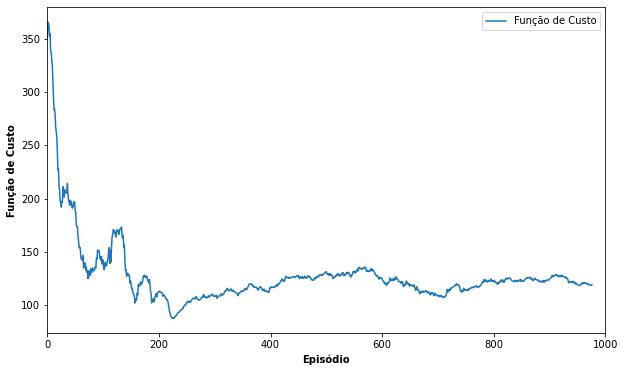

In [104]:
import matplotlib.pyplot as plt

plt.figure (figsize= (10,6))

plt.plot(media_movel_loss, label='Função de Custo')
# plt.plot(media_movel_mean_q, label='Q-Valor Médio', linestyle='dashed')
# plt.hlines(y=mean_rl, xmin=0, xmax=len(train_rwd), linestyles='--', color='green', label='Média Modelo Treinado')
# plt.hlines(y=final_rwd, xmin=0, xmax=len(train_rwd), linestyles='--', color='green', label='Média Modelo Treinado')
# plt.hlines(y=mean_fx, xmin=0, xmax=len(train_rwd), linestyles='--', color='red', label='Média Tempo Fixo')


# plt.title('Reward: RL x Tempo Fixo',fontweight="bold")
plt.xlabel('Episódio',fontweight="bold")
plt.ylabel('Função de Custo',fontweight="bold")
# plt.axvspan(400, 800, alpha=0.25, color='gray', label='Período de Teste')
plt.xlim(0,1000)
plt.legend(loc='upper right')
# plt.xticks(np.arange(0, len(train_rwd

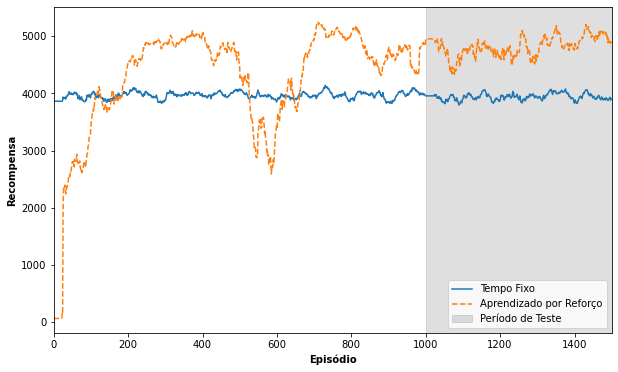

In [111]:
import matplotlib.pyplot as plt

plt.figure (figsize= (10,6))
plt.plot(list(media_movel_fx_score) + list(media_movel_fx_score2), label='Tempo Fixo')
plt.plot(media_movel_episode_reward + media_movel_episode_reward2, label='Aprendizado por Reforço', linestyle='dashed')

plt.xlabel('Episódio',fontweight="bold")
plt.ylabel('Recompensa',fontweight="bold")
plt.axvspan(1000, 1500, alpha=0.25, color='gray', label='Período de Teste')
plt.xlim(0,1500)
plt.legend(loc='lower right')

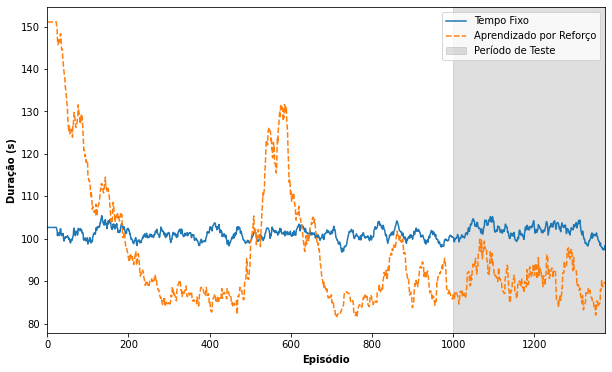

In [113]:
import matplotlib.pyplot as plt

media_movel_tp_var = (n_media_movel-1)*[np.array([float(x) for x in tp_var_list[0:n_media_movel-1]]).mean()] + list(moving_average([float(x) for x in tp_var_list],n_media_movel))
media_movel_tp_fx = (n_media_movel-1)*[np.array([float(x) for x in tp_fix_list[0:n_media_movel-1]]).mean()] + list(moving_average([float(x) for x in tp_fix_list],n_media_movel))

plt.figure (figsize= (10,6))

plt.plot(media_movel_tp_fx, label='Tempo Fixo')
plt.plot(media_movel_tp_var, label='Aprendizado por Reforço', linestyle='dashed')



plt.xlabel('Episódio',fontweight="bold")
plt.ylabel('Duração (s)',fontweight="bold")
plt.axvspan(1000, 1500, alpha=0.25, color='gray', label='Período de Teste')
plt.xlim(0,1375)
plt.legend(loc='upper right')